In [1]:
from modsim import *

In [3]:
A = Vector(3, 4)
mag, theta = vector_mag(A), vector_angle(A)
mag, theta

(np.float64(5.0), np.float64(0.9272952180016122))

In [4]:
x, y = pol2cart(theta, mag)
C = Vector(x, y)
C

x    3.0
y    4.0
Name: component, dtype: float64

In [5]:
A / vector_mag(A)

x    0.6
y    0.8
Name: component, dtype: float64

In [6]:
A_hat = vector_hat(A)
A_hat

x    0.6
y    0.8
Name: component, dtype: float64

In [9]:
params = Params(
    x=0, # m
    y=1, # m
    angle=45, # degree
    speed=40, # m / s

    mass=145e-3, # kg
    diameter=73e-3, # m
    C_d=0.33, # dimensionless

    rho=1.2, # kg/m**3
    g=9.8, # m/s**2
    t_end=10, # s
)

In [7]:
from numpy import pi, deg2rad
def make_system(params):
    # convert angle to radians
    theta = deg2rad(params.angle)

    # compute x and y components of velocity
    vx, vy = pol2cart(theta, params.speed)

    # make the initial state
    init = State(x=params.x, y=params.y, vx=vx, vy=vy)

    # compute the frontal area
    area = pi * (params.diameter/2)**2

    # return system
    return System(params, init=init, area=area)

In [10]:
system = make_system(params)
system.init

x      0.000000
y      1.000000
vx    28.284271
vy    28.284271
Name: state, dtype: float64

In [17]:
def drag_force(V, system):
    rho, C_d, area = system.rho, system.C_d, system.area
    mag = rho * vector_mag(V)**2 * C_d * area / 2
    direction = -vector_hat(V)
    f_drag = mag * direction
    return f_drag

In [19]:
vx, vy = system.init.vx, system.init.vy
V_test = Vector(vx, vy)
f_drag = drag_force(V_test, system)
f_drag

x   -0.937574
y   -0.937574
Name: component, dtype: float64

In [20]:
def slope_func(t, state, system):
    x, y, vx, vy = state
    mass, g = system.mass, system.g
    V = Vector(vx, vy)
    a_drag = drag_force(V, system) / system.mass
    a_grav = Vector(0, -g)
    A = a_grav + a_drag
    return V.x, V.y, A.x, A.y

In [21]:
slope_func(0, system.init, system)

(np.float64(28.284271247461902),
 np.float64(28.2842712474619),
 np.float64(-6.466030881564545),
 np.float64(-16.266030881564546))

In [22]:
def event_func(t, state, system):
    x, y, vx, vy = state
    return y

In [23]:
event_func(0, system.init, system)

1.0

In [25]:
results, details = run_solve_ivp(system, slope_func, events=event_func)
details.message

'A termination event occurred.'

In [26]:
results.tail()

,x,y,vx,vy
4.804692,96.438515,4.284486,14.590855,-20.726780
4.854740,97.166460,3.238415,14.484772,-21.065476
4.904789,97.889087,2.175515,14.378566,-21.400392
4.954838,98.606374,1.095978,14.272264,-21.731499
5.004887,99.318296,0.000000,14.165894,-22.058763


In [27]:
flight_time = results.index[-1]
flight_time

np.float64(5.004887034868346)

In [28]:
final_state = results.iloc[-1]
final_state

x     99.318296
y      0.000000
vx    14.165894
vy   -22.058763
Name: 5.004887034868346, dtype: float64

In [29]:
x_dist = final_state.x
x_dist

np.float64(99.31829628352207)

In [30]:
final_V = Vector(final_state.vx, final_state.vy)
final_V

x    14.165894
y   -22.058763
Name: component, dtype: float64

In [31]:
vector_mag(final_V)

np.float64(26.215674453237572)

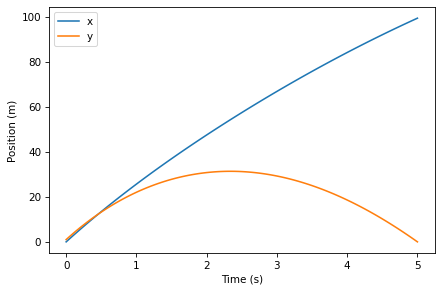

In [32]:
results.x.plot()
results.y.plot()
decorate(xlabel='Time (s)',ylabel='Position (m)')

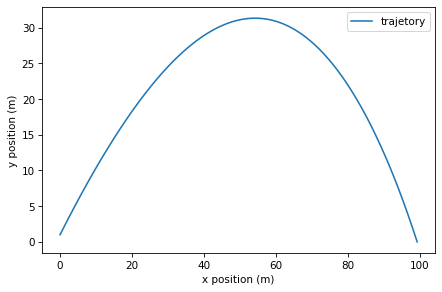

In [33]:
def plot_trajetory(results):
    x = results.x
    y = results.y
    make_series(x, y).plot(label='trajetory')
    decorate(xlabel='x position (m)', ylabel='y position (m)')

plot_trajetory(results)


In [35]:
from numpy import rad2deg
rad2deg(vector_angle(final_V))

np.float64(-57.29187097821225)

In [36]:
from matplotlib.pyplot import plot
xlim = results.x.min(), results.x.max()
ylim = results.y.min(), results.y.max()
def draw_func(t, state):
    # plot(state.x, state.y, 'bo', update=True)
    plot(state.x, state.y, 'bo')
    decorate(xlim=xlim, ylim=ylim, xlabel='x position (m)', ylabel='y position (m)')

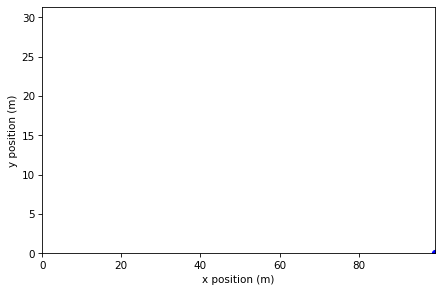

In [38]:
animate(results, draw_func)

In [39]:
# Exercise 22.1
# Run the simulation with and without air resistance. 
# How wrong would we be if we ignored drag?
# Hint
system2 = make_system(params.set(C_d=0))

In [41]:
results2, details2 = run_solve_ivp(system2, slope_func, events=event_func)
details2.message

'A termination event occurred.'

In [44]:
def plot_trajetory(results, label='trajetory'):
    x = results.x
    y = results.y
    make_series(x, y).plot(label=label)
    decorate(xlabel='x position (m)', ylabel='y position (m)')

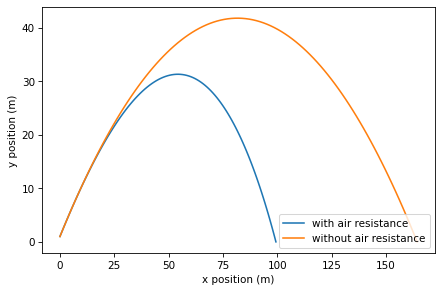

In [46]:
plot_trajetory(results, label='with air resistance')
plot_trajetory(results2, label='without air resistance')

In [47]:
# Exercise 22.2

# The baseball stadium in Denver, Colorado, is 1,580 m above sea level, 
# where the density of air is about 1.0 kg/m3. Compared with the example 
# near sea level, how much farther would a ball travel if hit with the same 
# initial speed and launch angle?
# Hint
system3 = make_system(params.set(rho=1.0))

In [48]:
results3, details3 = run_solve_ivp(system3, slope_func, events=event_func)
details3.message

'A termination event occurred.'

In [51]:
results3.iloc[-1].x - results.iloc[-1].x

np.float64(6.4700837750757785)

### Exercise 3

 The model so far is based on the assumption that coefficient of drag does not depend on velocity, but in reality it does.  The following figure, from Adair, *The Physics of Baseball*, shows coefficient of drag as a function of velocity (see <https://books.google.com/books/about/The_Physics_of_Baseball.html?id=4xE4Ngpk_2EC>).

![Graph of drag coefficient versus velocity](./baseball_drag.png)

I used an online graph digitizer (<https://automeris.io/WebPlotDigitizer>) to extract the data and save it in a CSV file.  

In [71]:
from pandas import read_csv
baseball_drag = read_csv('baseball_drag.csv')
baseball_drag.head(), baseball_drag.tail()

(   Velocity in mph  Drag coefficient
 0         0.058486           0.49965
 1        19.845000           0.49878
 2        39.476000           0.49704
 3        50.181000           0.48225
 4        60.134000           0.45004,
     Velocity in mph  Drag coefficient
 11           104.54           0.30035
 12           113.83           0.28816
 13           120.90           0.28381
 14           127.34           0.28033
 15           134.41           0.28207)

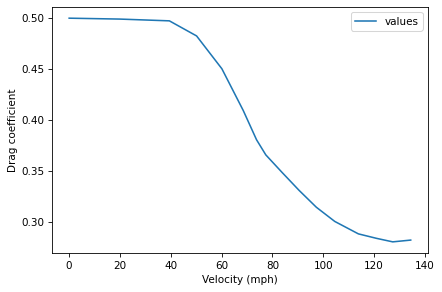

In [66]:
make_series(baseball_drag['Velocity in mph'], baseball_drag['Drag coefficient']).plot()
decorate(xlabel='Velocity (mph)', ylabel='Drag coefficient')

In [67]:
from pint import UnitRegistry
units = UnitRegistry()

In [69]:
mph_to_mps = (1 * units.mph).to(units.m/units.s).magnitude
speed = baseball_drag['Velocity in mph'] * mph_to_mps

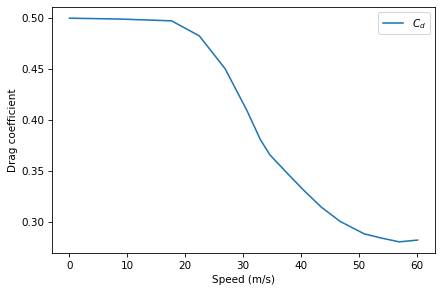

In [70]:
C_d_series = make_series(speed, baseball_drag['Drag coefficient'])
C_d_series.plot(label='$C_d$')
decorate(xlabel='Speed (m/s)', ylabel='Drag coefficient')

In [72]:
drag_interp = interpolate(C_d_series)
drag_interp(30)

array(0.41607879)

In [75]:
def drag_force_cdi(V, system):
    rho, _, area = system.rho, system.C_d, system.area
    C_d = drag_interp(vector_mag(V))
    mag = rho * vector_mag(V)**2 * C_d * area / 2
    direction = -vector_hat(V)
    f_drag = mag * direction
    return f_drag

def slope_func_cdi(t, state, system):
    x, y, vx, vy = state
    mass, g = system.mass, system.g
    V = Vector(vx, vy)
    a_drag = drag_force_cdi(V, system) / system.mass
    a_grav = Vector(0, -g)
    A = a_grav + a_drag
    return V.x, V.y, A.x, A.y

slope_func_cdi(0, system.init, system)

(np.float64(28.284271247461902),
 np.float64(28.2842712474619),
 np.float64(-6.534891184395128),
 np.float64(-16.334891184395126))

In [76]:
results_cdi, details_cdi = run_solve_ivp(system, slope_func_cdi, events=event_func)
details_cdi.message

'A termination event occurred.'

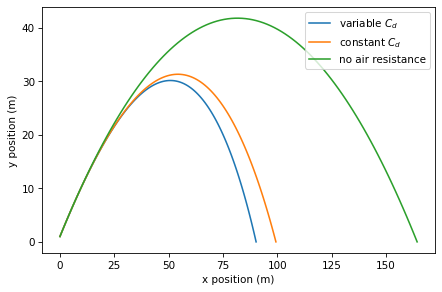

In [79]:
plot_trajetory(results_cdi, label='variable $C_d$')
plot_trajetory(results, label='constant $C_d$')
plot_trajetory(results2, label='no air resistance')